# COMP5318: Assignment 2 SVM with HOG

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from skimage.feature import hog
from skimage import color

from sklearn import svm
import timeit

% matplotlib inline

Using TensorFlow backend.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2) Import the data / Train, Test, Split (CF100)


Try with 10 coarse classes

### Import the Data 

In [0]:
# used to unwrap data
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [0]:
# fine labels
# train data CF100
if False:
  data_train = unpickle('/content/drive/My Drive/Colab Notebooks/Assignment_2/train')
  x_train = data_train[b'data']
  y_train = np.array(data_train[b'fine_labels'])

In [0]:
# coarse labels
# train data CF100
if True:
  data_train = unpickle('/content/drive/My Drive/Colab Notebooks/Assignment_2/train')
  x_train = data_train[b'data']
  y_train = np.array(data_train[b'coarse_labels'])

In [9]:
print(x_train.shape)
print(y_train.shape)

(50000, 3072)
(50000,)


In [0]:
# fine labels
if False:
  # test data CF100
  data_test= unpickle('/content/drive/My Drive/Colab Notebooks/Assignment_2/test')
  x_test= data_test[b'data']
  y_test= np.array(data_test[b'fine_labels'])

In [0]:
# coarse labels
if True:
  # test data CF100
  data_test= unpickle('/content/drive/My Drive/Colab Notebooks/Assignment_2/test')
  x_test= data_test[b'data']
  y_test= np.array(data_test[b'coarse_labels'])

In [12]:
print(x_test.shape)
print(y_test.shape)

(10000, 3072)
(10000,)


### Map English Names to Labels

#### Training Names

In [0]:
# Preprocess names to take away file extensions
names_train_raw = data_train[b'filenames']

names_train = []

for x in names_train_raw:
  name_str = x.decode("utf-8")
  ic = name_str.find('_s_')
  name = name_str[:ic]
  names_train.append(name)

In [0]:
# make tuple of names to label
l_n_train = [(y_train[i], x) for i, x in enumerate(names_train)]

#### Testing Names

In [0]:
# Preprocess names to take away file extensions
names_test_raw = data_test[b'filenames']

names_test = []

for x in names_test_raw:
  name_str = x.decode("utf-8")
  ic = name_str.find('_s_')
  name = name_str[:ic]
  names_test.append(name)

In [0]:
# make tuple of names to label
l_n_test = [(y_test[i], x) for i, x in enumerate(names_test)]

### Check All the Components are Imported

In [13]:
x_train.shape

(50000, 3072)

In [14]:
y_train.shape

(50000,)

In [15]:
x_test.shape

(10000, 3072)

In [16]:
y_test.shape

(10000,)

## 3) Explore the Data / Graphs and Correlations

# What does the data look like?


In [17]:
x_train[0].shape

(3072,)

In [18]:
y_train[0]

11

In [0]:
# Reshape the image
image = x_train[1].reshape(3, 32, 32)
image_reshape = np.transpose(image, (1, 2, 0))


In [0]:
# Turn original image into reshaped image
image = image_reshape

In [0]:
label = l_n_train[1]

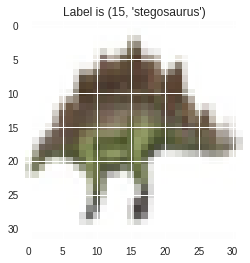

In [26]:
plt.title('Label is {label}'.format(label=label))
plt.imshow(image)
plt.show()

# Print out a few examples

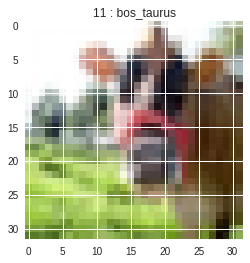

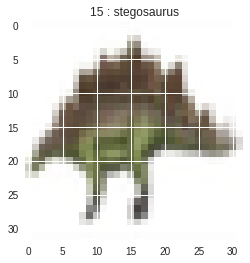

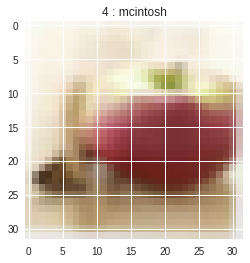

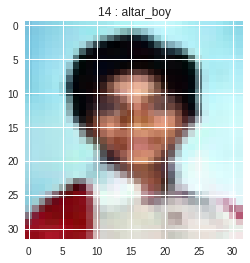

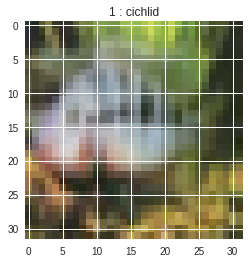

In [27]:
for img, y in zip(x_train[0:5], l_n_train[0:5]):
    image = img.reshape(3, 32, 32)
    image = np.transpose(image, (1, 2, 0))
    label = y[0]
    name = y[1]
    plt.title('{label} : {name}'.format(label=label, name=name))
    plt.imshow(image)
    plt.show()

# Setup

In [0]:
batch_size = 256
num_classes = 20
epochs = 12 # 12 epoch for best results

# input image dimensions
# need to know how big your images are here 
img_rows, img_cols, channels = 32, 32, 3

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], channels, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], channels, img_rows, img_cols)
    input_shape = (channels, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
    input_shape = (img_rows, img_cols, channels)

# Prepare Data and Normalise

In [29]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000,)
50000 train samples
10000 test samples


## Turn RGB to Grayscale

In [0]:
x_train = [ color.rgb2gray(i) for i in x_train]
x_test = [ color.rgb2gray(i) for i in x_test]


## Get the HOG of each image

In [31]:
t1 = timeit.default_timer()

hog_images = []

count = 0
ppc = 8
x_train_hog = []
for image in x_train:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(1, 1),block_norm= 'L2',visualise=True)
    x_train_hog.append(fd)
    hog_images.append(hog_image)
    count+=1
    if count % 2000 == 0:
      print("Done " , count)
    
count = 0
x_test_hog = []
for image in x_test:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(1, 1),block_norm= 'L2',visualise=True)
    x_test_hog.append(fd)
    hog_images.append(hog_image)
    count+=1
    if count % 2000 == 0:
      print("Done " , count)
      
t2 = timeit.default_timer()
print('Time:', t2-t1)

Done  2000
Done  4000
Done  6000
Done  8000
Done  10000
Done  12000
Done  14000
Done  16000
Done  18000
Done  20000
Done  22000
Done  24000
Done  26000
Done  28000
Done  30000
Done  32000
Done  34000
Done  36000
Done  38000
Done  40000
Done  42000
Done  44000
Done  46000
Done  48000
Done  50000
Done  2000
Done  4000
Done  6000
Done  8000
Done  10000
Time: 205.835252537001


## Print a few HOG images

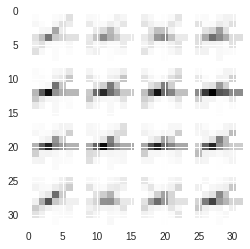

In [32]:
plt.imshow(hog_images[11])


## SVM and result

In [0]:
t1 = timeit.default_timer()

clf = svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=1, max_iter=-1, decision_function_shape='ovr', random_state=None)
clf.fit(x_train_hog, y_train)
t2 = timeit.default_timer()
train_time = t2-t1
print('Train time:', train_time)
result = clf.score(x_test_hog, y_test)
print('Accuracy:', result)

t2 = timeit.default_timer()
test_time = t2-train_time
print('Test time:', test_time)

[LibSVM]

## SVM Cross Validate

In [0]:
# Evaluate with 10-Fold Cross Validation
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn import model_selection

scoring = {'accuracy': 'accuracy',
           'precision': 'precision_macro',
           'recall': 'recall_macro',
          'f1' : 'f1_macro'}

kfold = model_selection.KFold(n_splits=10, random_state=42);
clf = svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', random_state=None);

results = model_selection.cross_validate(estimator=model,
                                          X=x_train_hog,
                                          y=y_train,
                                          cv=kfold,
                                        scoring=scoring, verbose=2);

[CV]  ................................................................
[CV] ................................................. , total=14.5min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 42.9min remaining:    0.0s


[CV] ................................................. , total=14.5min
[CV]  ................................................................
[CV] ................................................. , total=14.9min
[CV]  ................................................................


In [0]:
from statistics import mean
# Print Results of Cross-Validation
test_accuracy = results['test_accuracy']
test_precision = results['test_precision']
test_recall = results['test_recall']
test_f1 = results['test_f1']


print('average test_accuracy of cross-valiudation is {0:.4f}'.format(mean(test_accuracy)))
print('average test_precision of cross-valiudation is {0:.4f}'.format(mean(test_precision)))
print('average test_recall of cross-valiudation is {0:.4f}'.format(mean(test_recall)))
print('average test_f1 of cross-valiudation is {0:.4f}'.format(mean(test_f1)))

## Confusion matrix

In [0]:
from sklearn.metrics import classification_report;

predictions = clf.predict(x_test_hog);

print(classification_report(y_test, predictions));

### HOG takes: 582.2855162970009 seconds

### HOG param: cells_per_block=(4, 4), PPC = 8
### Default Parameters

Using first 5000 training set, first 5000 test set

* Train time: 9.225744007999992
* Accuracy: 0.0724
* Test time: 14.000498560999972


Using first 10000 training set, first 10000 test set

* Train time: 37.61121744500008
* Accuracy: 0.0687
* Test time: 56.66864427799999

Using all training set, first 5000 test set
* Train time: 974.2101461210001
* Accuracy: 0.1568
* Test time: 1026.976017176

Using all training set, all test set
* Accuracy: 0.1599
* Test time: 122.91257156399979

### HOG param: cells_per_block=(1, 1), PPC = 16
### Extreme fast parameters

Using first 5000 training set, first 5000 test set
* Train time: 3.5292261279996637
* Accuracy: 0.1064
* Test time: 5.5163444059999165

Using all training set, all test set
* Train time: 408.387773852
* Accuracy: 0.1514
* Test time: 448.31752536500017

### HOG param: cells_per_block=(1, 1), PPC = 8
### Preferred parameters

Using first 5000 training set, first 5000 test set, cell per block(1,1)
* Train time: 8.726542168000378
* Accuracy: 0.113
* Test time: 13.507322971000121

Using all training set, all test set
* Train time: 1634.4581852789997
* Accuracy: 0.1754
* Test time: 1880.0568681230006


# END CODE